# LSTM

- reference: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Omajinai

In [1]:
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout#, GRU, Bidirectional
import tensorflow as tf

## Data

In [3]:
!wget https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv -O newly_confirmed_cases_daily.csv

--2022-01-06 20:55:45--  https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv
Resolving covid19.mhlw.go.jp (covid19.mhlw.go.jp)... 18.65.148.99, 18.65.148.47, 18.65.148.42, ...
Connecting to covid19.mhlw.go.jp (covid19.mhlw.go.jp)|18.65.148.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95648 (93K) [application/octet-stream]
Saving to: ‘newly_confirmed_cases_daily.csv’

newly_confirmed_cas 100%[===================>]  93.41K  --.-KB/s    in 0.02s   

2022-01-06 20:55:45 (3.81 MB/s) - ‘newly_confirmed_cases_daily.csv’ saved [95648/95648]



In [4]:
df = pd.read_csv('newly_confirmed_cases_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)
print(df.shape)
display(df.head(1))
display(df.tail(5))

(721, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,457,23,0,1,0,0,0,3,1,17,...,0,0,18,0,1,0,0,0,0,52
2022-01-02,479,16,1,1,1,0,0,6,2,10,...,0,0,7,0,1,0,0,0,1,51
2022-01-03,673,10,3,3,2,0,1,1,2,12,...,0,0,10,6,1,1,1,1,5,130
2022-01-04,1151,26,6,1,6,0,0,2,10,33,...,3,4,19,0,6,1,1,0,5,225
2022-01-05,2491,34,6,4,6,0,14,13,16,30,...,6,5,46,15,16,4,2,3,19,623


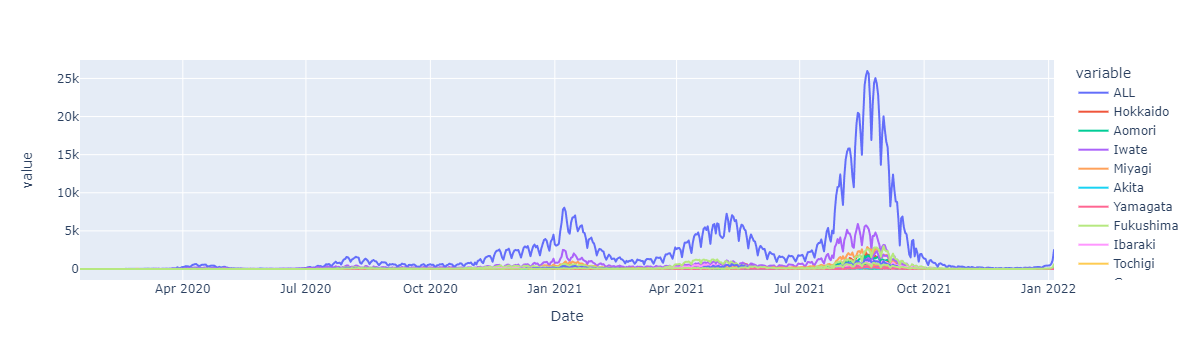

In [5]:
px.line(df, )

In [6]:
df_gr = df.groupby(pd.Grouper(level='Date', freq='W')).mean()
df_gr = df_gr.drop(df_gr.index[-1])
print(df_gr.shape)
display(df_gr.head(1))
display(df_gr.tail(5))

(103, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-19,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-05,111.857143,5.428571,0.000000,0.000000,0.285714,1.142857,6.142857,0.142857,0.000000,1.714286,...,0.0,0.000000,5.428571,0.000000,0.000000,0.142857,0.142857,0.285714,0.000000,3.000000
2021-12-12,114.857143,3.428571,0.428571,0.000000,0.428571,0.142857,1.000000,1.000000,2.000000,1.571429,...,0.0,0.000000,3.857143,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,3.428571
2021-12-19,148.142857,8.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,1.142857,1.571429,...,0.0,0.000000,2.571429,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.571429
2021-12-26,216.857143,19.142857,0.000000,0.000000,0.285714,0.000000,0.142857,2.428571,1.571429,5.714286,...,0.0,0.000000,10.571429,0.428571,0.571429,0.142857,0.000000,0.000000,1.428571,18.142857
2022-01-02,384.000000,21.285714,0.285714,0.714286,0.428571,0.000000,0.142857,2.428571,1.571429,12.142857,...,0.0,0.142857,6.857143,0.857143,0.428571,0.000000,0.000000,0.000000,0.428571,36.857143


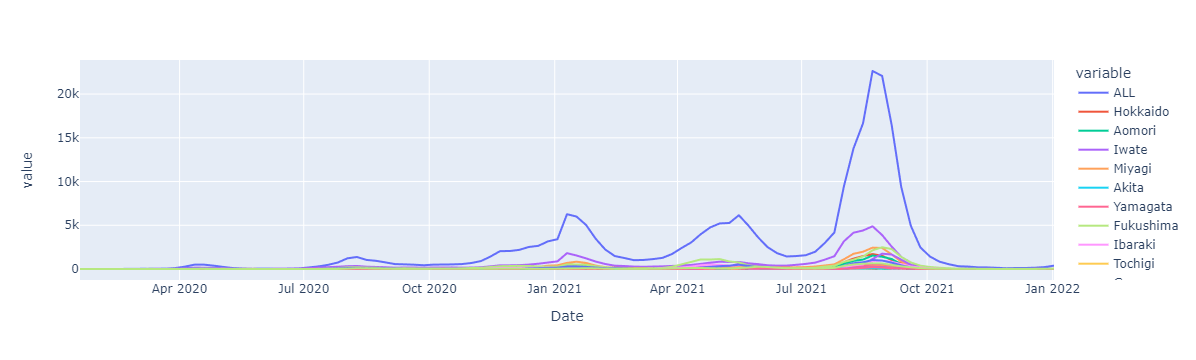

In [7]:
px.line(df_gr,)

### Scale

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
ts_all = df_gr.ALL
ts_all_sc = sc.fit_transform(ts_all.values.reshape(-1, 1)).ravel()
ts_all_sc = pd.Series(ts_all_sc, index=ts_all.index)
ts_all_sc.head(1)

Date
2020-01-19    0.0
Freq: W-SUN, dtype: float64

### FE

In [9]:
forecast_weeks = 12
# df_fe = df_gr.ALL.to_frame()
df_fe = ts_all_sc.to_frame(name='ALL')

# add new rows for forecast
index_list = pd.date_range(ts_all_sc.index[-1]+relativedelta(weeks=1), ts_all_sc.index[-1]+relativedelta(weeks=forecast_weeks), freq='W')
df_fe = pd.concat([df_fe, pd.DataFrame(index=index_list)])

# shift
for i in range(forecast_weeks, forecast_weeks+12):
    df_fe[f'ALL_{i}_week_ago'] = df_fe.ALL.shift(i)
# df_fe[f'ALL_12_week_ago'] = df_fe.ALL.shift(12)
df_fe['year'] = df_fe.index.year
df_fe['month'] = df_fe.index.month
df_fe['weekofyear'] = df_fe.index.isocalendar().week
df_fe = df_fe.astype('float')
df_fe = df_fe.loc[df_fe.ALL_23_week_ago.dropna().index, :]
df_fe

,ALL,ALL_12_week_ago,ALL_13_week_ago,ALL_14_week_ago,ALL_15_week_ago,ALL_16_week_ago,ALL_17_week_ago,ALL_18_week_ago,ALL_19_week_ago,ALL_20_week_ago,ALL_21_week_ago,ALL_22_week_ago,ALL_23_week_ago,year,month,weekofyear
2020-06-28,0.003517,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,0.000039,0.000008,0.000000,2020.0,6.0,26.0
2020-07-05,0.008023,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,0.000039,0.000008,2020.0,7.0,27.0
2020-07-12,0.013331,0.021883,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,0.000039,2020.0,7.0,28.0
2020-07-19,0.021271,0.016771,0.021883,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,2020.0,7.0,29.0
2020-07-26,0.032663,0.010371,0.016771,0.021883,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,2020.0,7.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,NaN,0.004931,0.003965,0.005991,0.007916,0.008471,0.012265,0.013969,0.023846,0.037106,0.063273,0.109586,0.219038,2022.0,2.0,8.0
2022-03-06,NaN,0.005063,0.004931,0.003965,0.005991,0.007916,0.008471,0.012265,0.013969,0.023846,0.037106,0.063273,0.109586,2022.0,3.0,9.0
2022-03-13,NaN,0.006534,0.005063,0.004931,0.003965,0.005991,0.007916,0.008471,0.012265,0.013969,0.023846,0.037106,0.063273,2022.0,3.0,10.0
2022-03-20,NaN,0.009570,0.006534,0.005063,0.004931,0.003965,0.005991,0.007916,0.008471,0.012265,0.013969,0.023846,0.037106,2022.0,3.0,11.0


### split

In [10]:
X = df_fe.drop('ALL', axis=1)
y = df_fe.ALL
print(X.shape, y.shape)

(92, 15) (92,)


## functions

In [11]:
# https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.Inf
        self.best_map10 = 0

    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')
        map10=logs.get('val_average_precision_at_k10')

        # If BOTH the validation loss AND map10 does not improve for 'patience' epochs, stop training early.
        if np.less(v_loss, self.best_v_loss) and np.greater(map10, self.best_map10):
            self.best_v_loss = v_loss
            self.best_map10 = map10
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

In [12]:
n_units = 32
n_batch_size = 32
n_epochs = 10000

from keras.callbacks import EarlyStopping
es_loss = EarlyStopping(monitor='loss', patience=100)
es_val_loss = EarlyStopping(monitor='loss', patience=100)

def trainLSTM(X_train, y_train):
    tf.random.set_seed(42)
    
    # val
    X_val = X_train[X_train.index == X_train.index[-1]]
    X_train = X_train.drop(X_train.index[-1])
    y_val = y_train[y_train.index == y_train.index[-1]]
    y_train = y_train.drop(y_train.index[-1])
    
    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    # Second LSTM layer
    model.add(LSTM(units=n_units, return_sequences=True))
    model.add(Dropout(0.2))
    # Third LSTM layer
    model.add(LSTM(units=n_units, return_sequences=True))
    model.add(Dropout(0.2))
    # Fourth LSTM layer
    model.add(LSTM(units=n_units))
    model.add(Dropout(0.2))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fitting to the training set
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=n_epochs, batch_size=n_batch_size, verbose=0, callbacks=[es_val_loss])

    return model, history

## forecast

(79, 15) (79,)


2022-01-06 20:55:47.597825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 20:55:47.732285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 20:55:47.732791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 20:55:47.734202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

loss: 0.0060004
val_loss: 0.00029658
CPU times: user 49.6 s, sys: 16.3 s, total: 1min 5s
Wall time: 54.4 s


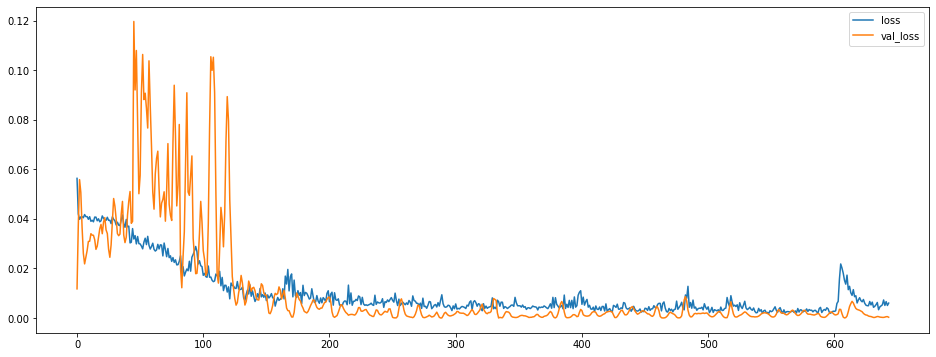

In [13]:
%%time

train_last_date = '2021-12-26'
X_train = X[X.index <= train_last_date]
y_train = y[y.index <= train_last_date]
print(X_train.shape, y_train.shape)

model, history = trainLSTM(X_train, y_train)
print('loss: {:.5}'.format(history.history['loss'][-1]))
print('val_loss: {:.5}'.format(history.history['val_loss'][-1]))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

RMSE: 1106.5


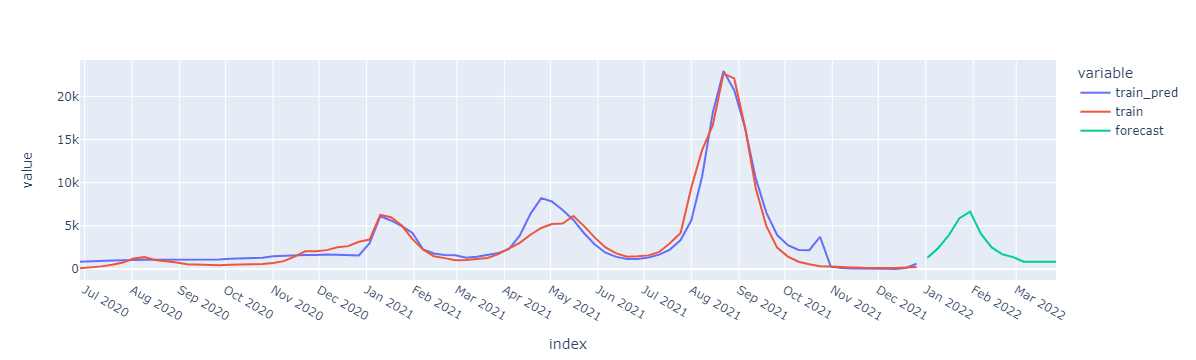

In [14]:
X_train = X[X.index <= train_last_date]
y_train = y[y.index <= train_last_date]
y_train_index = y_train.index

y_pred = model.predict(X_train)
y_pred = sc.inverse_transform(y_pred).ravel()
y_pred = pd.Series(y_pred, index=y_train_index, name='train_pred')
y_train = sc.inverse_transform(y_train.values.reshape(-1, 1)).ravel()
y_train = pd.Series(y_train, index=y_train_index, name='train')

rmse = np.sqrt( mean_squared_error(y_train, y_pred) )
print('RMSE: {:.5}'.format(rmse))

X_forecast = X[X.index > train_last_date]
y_forecast = y[y.index > train_last_date]
y_forecast_index = y_forecast.index

y_forecast = model.predict(X_forecast)
y_forecast = sc.inverse_transform(y_forecast).ravel()
y_forecast = pd.Series(y_forecast, index=y_forecast_index, name='forecast')

# plt.plot(y_pred, label='train pred')
# plt.plot(y_train, label='test')
# plt.plot(y_forecast, label='forecast')
# plt.legend()

fig = px.line(pd.concat([y_pred, y_train, y_forecast], axis=1))
fig.update_layout({
    'xaxis': {
        'dtick': 'M1'
    }
})
fig.show()

## benchmark

In [15]:
%%time
def auto(X, y):
    pass

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


In [16]:
# Preparing X_test and predicting
X_test = []
index_list = []
for i in range(n_timestep, ts_test_sc.shape[0]):
    X_test.append(ts_test_sc.iloc[i-n_timestep:i])
    index_list.append(ts_test_sc.iloc[i].name)
X_test = np.array(X_test)
print(X_test.shape)

NameError: name 'n_timestep' is not defined

In [ ]:
y_pred = regressor.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
ts_pred = pd.DataFrame(y_pred, index=index_list, columns=['pred'])

In [ ]:
df_temp = pd.concat([ts_test, ts_pred], axis=1)
px.line(df_temp)